Philippe Joly MAIS 202

This is an implementation of a Long Short-Term Memory Network (LSTM) to predict Electrical Power Demand based on the Weather in Quebec

In [58]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime as dt
import os
from dotenv import load_dotenv
load_dotenv()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DATA

In [59]:
data = pd.read_csv(os.getenv("DATA"))
data['Date/Time (UTC)'] = pd.to_datetime(data['Date/Time (UTC)'])

day = 60*60*24
year = 365.2425*day
week = 7*day
data['Seconds'] = data['Date/Time (UTC)'].map(pd.Timestamp.timestamp)
data['Day sin'] = np.sin(data['Seconds'] * (2* np.pi / day))
data['Day cos'] = np.cos(data['Seconds'] * (2 * np.pi / day))
data['week sin'] = np.sin(data['Seconds'] * (2 * np.pi / week))
data['week cos'] = np.cos(data['Seconds'] * (2 * np.pi / week))
data['Year sin'] = np.sin(data['Seconds'] * (2 * np.pi / year))
data['Year cos'] = np.cos(data['Seconds'] * (2 * np.pi / year))

data.drop(columns=['Year','Month','Day','Hour','Day of Week','Population', 'Seconds'], inplace=True)
data.set_index('Date/Time (UTC)', inplace=True)

column_order = ['Average Power Output (MW)'] + [col for col in data.columns if col != 'Average Power Output (MW)']
data = data[column_order]

In [60]:
data.head()

,Average Power Output (MW),Temp (°C),Day sin,Day cos,week sin,week cos,Year sin,Year cos
Date/Time (UTC),,,,,,,,
2019-01-01 00:00:00,NaN,-3.172212,-5.030095e-12,1.000000,-0.974928,-0.222521,0.002021,0.999998
2019-01-01 01:00:00,23762.55,-3.129954,2.588190e-01,0.965926,-0.982566,-0.185912,0.002738,0.999996
2019-01-01 02:00:00,23830.23,-3.200603,5.000000e-01,0.866025,-0.988831,-0.149042,0.003455,0.999994
2019-01-01 03:00:00,23608.07,-2.736991,7.071068e-01,0.707107,-0.993712,-0.111964,0.004172,0.999991
2019-01-01 04:00:00,23562.48,-1.625532,8.660254e-01,0.500000,-0.997204,-0.074730,0.004888,0.999988


# MODEL

In [61]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(LSTM, self).__init__()
        self.to(device)
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size//5)
        self.fc2 = nn.Linear(hidden_size//5, output_size)
        self.relu = nn.ReLU()

    def forward(self, X):
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device) 
        
        out, _ = self.lstm(X, (h0,c0))
        out = out[:,-1,:]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
    def getScale(self,X):
        self.means = []
        self.stds = []

        for i in range(self.input_size):
            self.means.append(np.mean(X[:,:,i]))
            self.stds.append(np.std(X[:,:,i]))

    def scaleX(self, X):
        for i in range(self.input_size):
            X[:,:,i] = (X[:,:,i]-self.means[i])/self.stds[i]
        return X
    
    def scaley(self, y):
        y = (y-self.means[0])/self.stds[0]
        return y
    
    def unscaley(self,y):
        y = y*self.stds[0]+self.means[0]
        return y
    
    def df_to_Xy(df, window_size):
        dfArr = df.to_numpy()
        X = []
        y= []
        for i in range(len(dfArr)-window_size):
            row = [r for r in dfArr[i:i+window_size]]

            if (np.isnan(row).any() or np.isnan(dfArr[i+window_size][0])):
                continue

            X.append(row)
            label = dfArr[i+window_size][0]
            y.append(label)
        return np.array(X), np.array(y)
    
    def data_split(df, train_perc=90, test_perc=5, window_size=6):
        X_tot, y_tot = LSTM.df_to_Xy(data, window_size)
        
        size = X_tot.shape[0]
        size_train = (size*train_perc)//100
        size_test = (size*test_perc)//100
        size_val = size-size_train-size_test
        
        X, y = X_tot[:size_train], y_tot[:size_train]
        X_val, y_val = X_tot[size_train:size_train+size_val], y_tot[size_train:size_train+size_val]
        X_test, y_test = X_tot[size_train+size_val:], y_tot[size_train+size_val:]

        return X, X_val, X_test, y, y_val, y_test
    
    def fit(self, X_train, y_train, X_val, y_val, num_epochs, batch_num, lr):
        batch_size = X_train.shape[0]//batch_num
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        self.train_losses = []
        self.val_losses = []
        self.it_ls = []

        self.getScale(X_train)
        X_train = torch.from_numpy(self.scaleX(X_train))
        y_train = torch.from_numpy(self.scaley(y_train))

        X_val = torch.from_numpy(self.scaleX(X_val)).to(torch.float32).to(device)
        y_val = torch.from_numpy(self.scaley(y_val)).to(torch.float32).to(device)

        train_load = torch.utils.data.TensorDataset(X_train,y_train)
        train_load = torch.utils.data.DataLoader(dataset=train_load, batch_size=batch_size, shuffle=True)

        for epoch in range(num_epochs):
            for i, (X, y) in enumerate(train_load):
                self.it_ls.append(epoch*len(train_load)+i)
                X= X.to(torch.float32).to(device)
                y = y.to(torch.float32).to(device)
                
                outputs = self.forward(X)
                outputs = outputs.reshape(outputs.shape[0])

                loss = criterion(outputs, y)
                self.train_losses.append(loss.item())

                with torch.no_grad():
                    val_outputs=self.forward(X_val)
                    self.val_losses.append(criterion(val_outputs.reshape(val_outputs.shape[0]), y_val).item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if((epoch*len(train_load)+i+1)%(num_epochs*len(train_load)//10+1)==0):
                    print(f'epoch: {epoch+1}/{num_epochs}, step {i+1}/{len(train_load)}, loss = {loss.item():.4f}')
    
    def train_score(self):
        print(f'Training Loss: {self.train_losses[-1]:.4f}')
        print(f'Validation Loss: {self.val_losses[-1]:.4f}')

        plt.plot(self.it_ls, self.train_losses, color="blue", label="Training Loss")
        plt.plot(self.it_ls, self.val_losses, color="red", label="Validation Loss")
        plt.xlabel("Batches")
        plt.ylabel("MSE")
        plt.title("Training and Validation MSE")
        plt.legend()
        plt.show()

    def test_score(self, X_test, y_test, scaled=False):
        with torch.no_grad():
            if(not scaled):
                X_test = self.scaleX(X_test)
            outputs = self.forward(torch.from_numpy(X_test).to(torch.float32).to(device)).to('cpu').detach().numpy()
            outputs = outputs.reshape(outputs.shape[0])
            y_pred = self.unscaley(outputs)

            print(f'MSE: {mean_squared_error(y_test, y_pred)}')
            print(f'R2: {r2_score(y_test, y_pred)}')
            print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

            return y_pred

    def save_model(self, name):
        time = dt.now().strftime("%y-%m-%d_%H:%M")
        f = f"../trainedModels/{name}_{time}.pth"
        torch.save(self.state_dict(), f)

# Training and Testing

In [62]:
X, X_val, X_test, y, y_val, y_test = LSTM.data_split(df=data, train_perc=85, test_perc=7, window_size=24)

model = LSTM(input_size=X.shape[2], output_size=1, num_layers=2, hidden_size=150)

In [63]:
model.fit(X_train=X, y_train=y, X_val=X_val, y_val=y_val, num_epochs=20, batch_num=4, lr=0.001)

epoch: 3/20, step 1/4, loss = 0.5562
epoch: 5/20, step 2/4, loss = 0.1926
epoch: 7/20, step 3/4, loss = 0.1405
epoch: 9/20, step 4/4, loss = 0.1030
epoch: 12/20, step 1/4, loss = 0.0843
epoch: 14/20, step 2/4, loss = 0.0744
epoch: 16/20, step 3/4, loss = 0.0693
epoch: 18/20, step 4/4, loss = 0.0641


Training Loss: 0.0576
Validation Loss: 0.0298


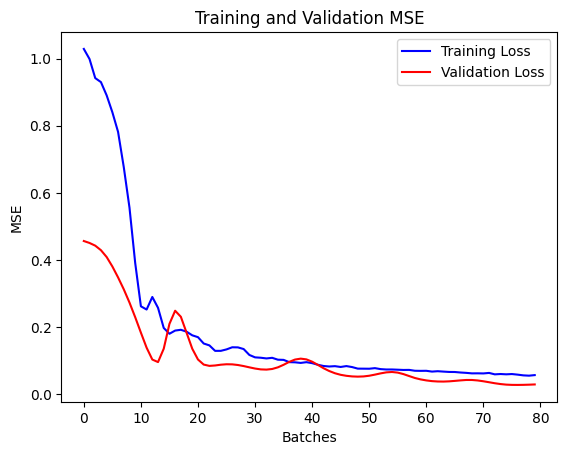

[[-0.3538702  -0.37602038 -0.41046076 -0.449706   -0.48126198 -0.43519688
  -0.3727263  -0.39125986 -0.46006648 -0.50970185 -0.59686407 -0.74201455
  -0.91397177 -1.017482   -1.10435133 -1.1585617  -1.18760589 -1.17979058
  -1.17361767 -1.09202219 -0.95465736 -0.79466224 -0.68516633 -0.62855352]
 [-0.37602038 -0.41046076 -0.449706   -0.48126198 -0.43519688 -0.3727263
  -0.39125986 -0.46006648 -0.50970185 -0.59686407 -0.74201455 -0.91397177
  -1.017482   -1.10435133 -1.1585617  -1.18760589 -1.17979058 -1.17361767
  -1.09202219 -0.95465736 -0.79466224 -0.68516633 -0.62855352 -0.58349685]
 [-0.41046076 -0.449706   -0.48126198 -0.43519688 -0.3727263  -0.39125986
  -0.46006648 -0.50970185 -0.59686407 -0.74201455 -0.91397177 -1.017482
  -1.10435133 -1.1585617  -1.18760589 -1.17979058 -1.17361767 -1.09202219
  -0.95465736 -0.79466224 -0.68516633 -0.62855352 -0.58349685 -0.6066295 ]
 [-0.449706   -0.48126198 -0.43519688 -0.3727263  -0.39125986 -0.46006648
  -0.50970185 -0.59686407 -0.74201455 

In [64]:
model.train_score()
y_pred = model.test_score(X_test=X_val, y_test=y_val, scaled=True)

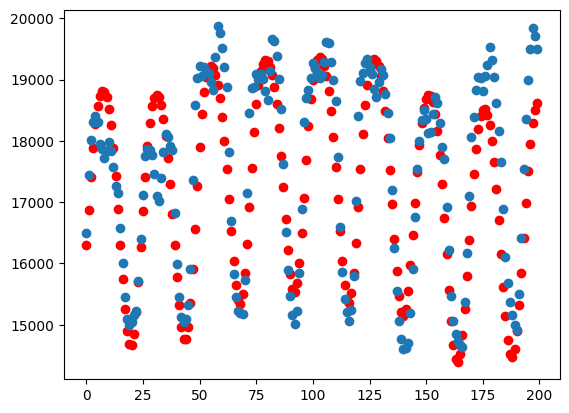

In [70]:
s=500
# l =y_pred.shape[0]
l=200
ind = np.zeros(l)
for i in range(l):
    ind[i] = i
plt.scatter(ind, y_pred[s:s+l],color="red")
plt.scatter(ind, y_val[s:s+l])

In [66]:
# s=0
# l =y_pred.shape[0]
# ind = np.zeros(l)
# y_pred = model.unscaley(y_pred)
# y_test = model.unscaley(y_test)
# for i in range(l):
#     ind[i] = i
# print(y_pred.shape)
# print(y_test.shape)
# print(ind.shape)
# plt.scatter(ind, y_pred,color="red")
# plt.scatter(ind, y_test)

In [67]:
#model.save_model(f"../trainedModels/lstm_1x128hid")